##  Unsupervised Learning Series

# 9.4  Recommender Systems

In this Section we discuss the fundamental linear *Recommender System*, a popular unsupervised learning framework commonly employed by businesses to help automatically recommend products and services to their customers.  From the vantage of machine learning however, the basic Recommender System detailed here is simply a slight twist on  our core unsupervised learning technique: Principal Component Analysis (PCA).  

## 9.4.1 Introduction and motivation

Recommender systems are heavily used in e-commerce today, providing customers with personalized recommendations for products and services by using a consumer's previous purchasing and rating history, along with those of similar customers.  For instance, a movie provider like Netflix with millions of users and tens of thousands of movies, records users' reviews and ratings (typically in the form of a number on a scale of 1-5 with 5 being the most favorable rating) in a large matrix such as the one illustrated below in the Figure. These matrices are very sparsely populated, since an individual consumer has likely rated only a small portion of the movies available. With this data available, online movie and commerce sites often use the unsupervised learning technique we discuss in this Section as their main technique for making personalized recommendations to customers regarding what they might like to watch / consume next. With the technique for producing personalized recommendations we discuss here - typically referred to as a *Recommender System* - we aim to intelligently guess the values of every missing entry in the ratings matrix (we *complete* the matrix).  Then, in order to recommend a new product to a given user, we examine our completely filled ratings matrix for products we have predicted the user would highly rate (and thus enjoy) and recommend these.  

<figure>
  <img src= '../../mlrefined_images/unsupervised_images/Fig_9_11.png' width="100%" height="auto" alt=""/>
  <figcaption>   
<strong>Figure 1:</strong> <em> A prototypical movie rating matrix is very sparsely populated, with each user having rated only a very small number of films. In this diagram movies are listed along rows with users along columns.  In order to properly recommend movies for users to watch we try to intelligently guess the missing values of this matrix, and then recommend movies that we predict users would highly rate (and therefore enjoy the most).
  </em>  </figcaption> 
</figure>

In [19]:
# This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
import matplotlib.pyplot as plt
import numpy as np
import copy

# custom libs
from mlrefined_libraries import unsupervised_library as unsuplib
datapath = '../../mlrefined_datasets/unsuperlearn_datasets/'

# this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 9.4.2  Formal modeling

In what follows we will use the familiar notation $\mathbf{x}_1,...,\mathbf{x}_P$ to denote our input data, each of which has dimension $N$.   Here $\mathbf{x}_p$ is our $p^{th}$ user's rating vector of - and is $N$ dimensional where $N$ is the total number of products / services available to be rated - and each is very sparsely populated (with whatever ratings user $p$ has input into the system).  Formally we can denote the index set of those products / services the $p^{th}$ user has rated - or in other words the index set of those non-empty entries of $\mathbf{x}_p$ - as

\begin{equation}
\Omega_p = \left \{\,\,j\,\,\rvert \,\,x_{j,\,p}  \,\,\text{exists}  \right \}.
\end{equation}

Note here that $x_{j,\,p}$ denotes the $j^{th}$ entry of the vector $\mathbf{x}_p$.


Stacking these user-rating vectors columnwise gives us our ratings matrix that we wish to complete

\begin{equation}
\mathbf{X} = \begin{bmatrix} 
\vert \,\,\,\,\,\, \vert \,\,\,\,\,...\,\,\,\,\vert \\
\mathbf{x}_1 \,\, \mathbf{x}_2 \,\,...\,\,\mathbf{x}_P \\
\vert \,\,\,\,\,\, \vert \,\,\,\,\,...\,\,\,\,\vert
\end{bmatrix}.
\end{equation}

In order to complete a sparsely populated ratings matrix effectively - because the data we are aiming to fill in is literally missing - we have no choice but to make assumptions about how users' tastes behave in general.   The most common / simplest assumption we can make - and the one we discuss here - is that every user's tastes can be expressed as a linear combination of some small set of fundamental user taste-profiles.  For example, in the case of movies these profiles could include the prototypical romance movie lover, prototypical comedy movie lover, action movie lover, etc.,  The relatively small number of such categories or user types compared to the total number of users or movies / products / etc., in a ratings matrix, provides a useful framework to intelligenty guess at the ratings matrix's missing values. 

How does this assumption help us complete the ratings matrix?  In order to find out we need to translate this intuitive assumption into mathematics.  When stated mathematically this assumption says that there are some set of $K < N$ prototypical user-rating profile basis vectors $\mathbf{c}_1,\,\mathbf{c}_2,\,..,\,\mathbf{c}_K$ so that we can express (approximately) every *complete* user-profile vector (given also the ideal weights in each linear combination) as 

\begin{equation}
\sum_{n=1}^K \mathbf{c}_n w_{n,\,p} \approx \mathbf{x}_p  \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1...P
\end{equation}

Again here we suppose that both the prototypical rating profile vectors $\mathbf{c}_1,\,...\,\mathbf{c}_K$ and the weights $w_{n,p}$ are ideal.  In practice we need to learn the proper values of these parameters, and from here we could then propose to square the difference of each desired approximation above and sum the result (which would give precisely the Least Squares cost function for PCA we derived in Section 9.2.1 and also 9.2.5).  But remember in the case of Recommender Systems we only have entries of $\mathbf{X}$ belonging to the index sets $\Omega_p$.  For each $p$ we will denote the desired approximation over only this index set as

\begin{equation}
\left.\left\{\sum_{n=1}^K \mathbf{c}_n w_{n,\,p} \approx \mathbf{x}_p \right\}\right\vert_{\,\Omega_p}  \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1...P.
\end{equation}

Squaring the difference between both sides of the above we can then form a Least Squares cost function for learning the parameters of our Recommneder System (that closely mirrors the one we derived for PCA, as written in Section 9.2.5) as


\begin{equation}
g\left(\mathbf{w}_1,...,\mathbf{w}_P,\mathbf{c}_1,...,\mathbf{c}_K\right) = \frac{1}{P}\sum_{p = 1}^P \left \Vert \left.\left\{ \sum_{n=1}^K\mathbf{c}_nw_{n,\,p} - \mathbf{x}_p \right\}\right\vert_{\,\Omega_p}\right\Vert_2^2
\end{equation}

## 9.4.3  Optimization

So far we have seen how the setup and cost function of the linear Recommender Systems model mirrors PCA very closely.  Now we discuss how to minimize the Least Squares cost function above in order to recover optimal settings for our parameter vectors $\mathbf{w}_1,...,\mathbf{w}_p$ and $\mathbf{c}_1,...,\mathbf{c}_K$.  In the case of PCA, we saw in Section 9.2.2 how the additional assumption that our basis is *orthonormal* allowed us to derive mathematically simple forms for our ideal parameter vectors.  However here the additional wrinkle of the Recommender Systems model - that we only have access to data whose indices lie in the set $\Omega$ - prohibits similar calculations.  Thus in short we must rely on an iterative method for learning ideal parameters here. 

Earlier in Section 9.2.5 we also saw how a simple *block-coordinate descent* approach, where we udpate one vector of parameters at a time, is a natural choice of algorithm to sequentially minimize the PCA cost function when the assumption of orthonormality is *not* enforced.  Because we now face the task of minimizing a highly related cost function for Recommender Systems it makes sense that we should apply the same approach, and so we will.  In other words, we will sequentially minimize the cost function above by sweeping through first the set of weights $\mathbf{w}_1,...,\mathbf{w}_P$ solving the first order system in each $\mathbf{w}_p$ independently with all other parameters fixed, and then we do the same for $\mathbf{c}_1,...,\mathbf{c}_K$.  Working carefully through the equations one can formulate very similar updates to ones derived for PCA in Section 9.2.5.  We summarize the form of these update steps below.

Denoting by $\mathbf{C}$ our $N\times K$ basis matrix as

\begin{equation}
\mathbf{C} = \begin{bmatrix} 
\vert \,\,\,\,\,\, \vert \,\,\,\,\,...\,\,\,\,\vert \\
\mathbf{c}_1 \,\, \mathbf{c}_2 \,\,...\,\,\mathbf{c}_K \\
\vert \,\,\,\,\,\, \vert \,\,\,\,\,...\,\,\,\,\vert
\end{bmatrix}
\end{equation}

and $\mathbf{C}_{\Omega_p}$ as the $\left\vert\Omega_p\right\vert \times K$ submatrix consisting of the $j^{th}$ row of $\mathbf{C}$ for each $j \in \Omega_p$ the update step for $\mathbf{w}_p$ can be written as 

\begin{equation}
\mathbf{C}_{\Omega_p}^T\mathbf{C}_{\Omega_p}^{\,}\mathbf{w}_p = \mathbf{C}_{\Omega_p}^T\mathbf{x}_p \,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, p=1...P .
\end{equation}

Notice how closely this resembles the analgous PCA update step given in equation (9.2.22).  Likewise the update step for $\mathbf{c}_n$ we can write the update step as 

\begin{equation}
\mathbf{c}_n = \frac{\sum_{p\, \text{if} \,n\in \Omega_p} \mathbf{x}_p w_{n,\,p} } {\sum_{p\, \text{if} \,n\in \Omega_p} w_{n,\,p}^2}\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\,\, n=1...K
\end{equation}

which mirrors the analagous update step for PCA given in equation (9.2.23). 

Sweeping through the parameter vectors and performing these updates a number of times results in a proper solution to the Least Squares cost function detailed above.  Below we collect these update steps in a pseudo-code block for convenience.  Comparing this procedure to the block-coordinate descent algorithm described in Section 9.2.5, notice unsuprisingly that if the ratings matrix $\mathbf{X}$ were *complete* these update steps would be precisely those given for the block-coordinate update steps for PCA.

### Recommender systems  (block-coordinate descent) 

<hr style="height:1px;border:none;color:#555;background-color:#555;">
<p style="line-height: 1.7;">
<strong>1:</strong>&nbsp;&nbsp; <strong>input:</strong> a number $K \leq N$ of desired basis elements, dataset $\mathbf{x}_1,...,\mathbf{x}_P$, initializations for basis $\mathbf{c}_1,...,\mathbf{c}_K$, and maximum number of iterations $\text{max_its}$ <br>

<strong>2:</strong>&nbsp;&nbsp; <code>for</code> $\,\,i = 1,\ldots,\text{max_its}$<br>

<strong>3:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code># Update weight vectors</code><br>

<strong>4:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>for</code> $\,\,p = 1,\ldots,P$<br>

<strong>5:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code> solve </code> $\mathbf{C}_{\Omega_p}^T\mathbf{C}_{\Omega_p}^{\,}\mathbf{w}_p = \mathbf{C}_{\Omega_p}^T\mathbf{x}_p$ <br>

<strong>6:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>end for</code><br>

<strong>7:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code># Update basis</code><br>

<strong>8:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>for</code> $\,\,n = 1,\ldots,K$<br>

<strong>9:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code> solve </code> $\mathbf{c}_n = \frac{\sum_{p\, \text{if} \,n\in \Omega_p} \mathbf{x}_p w_{n,\,p} } {\sum_{p\, \text{if} \,n\in \Omega_p} w_{n,\,p}^2}$ <br>

<strong>10:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code>end for</code><br>

<strong>11:</strong>&nbsp; <code>end for</code><br>

<strong>12:</strong>&nbsp;&nbsp; <code># Update weights on final basis</code><br>


<strong>13:</strong>&nbsp;&nbsp;&nbsp; <code>for</code> $\,\,p = 1,\ldots,P$<br>

<strong>14:</strong>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <code> solve </code> $\mathbf{C}_{\Omega_p}^T\mathbf{C}_{\Omega_p}^{\,}\mathbf{w}_p = \mathbf{C}_{\Omega_p}^T\mathbf{x}_p$ <br>

<strong>15:</strong>&nbsp;&nbsp; <code>end for</code><br>

<strong>16:</strong>&nbsp; <strong>output:</strong> optimal Recommender System basis $\mathbf{c}_1,...,\mathbf{c}_K$ and weights $\mathbf{w}_1,...,\mathbf{w}_P$<br>

<hr style="height:1px;border:none;color:#555;background-color:#555;">
</p>

Below we show a ``Python`` implementation of this algorithm.

In [125]:
# Recommender Systems Least Squares cost function - useful for debugging / checking progress
def recommender_cost_function(X,C,W):
    N,P = X.shape
    K,P = W.shape
    
    # loop over points and construct cost value iteratively
    cost = 0
    A = np.dot(C,W)
    for p in range(P):
        # find indices of pth ratings vector that exist
        ind = np.isnan(X[:,p])
        ind = np.argwhere(ind == False).ravel()
        
        # compute least squares term over each basis element
        x_p = X[:,p]
        a_p = A[:,p]
        
        # add current basis cost to total cost 
        cost += np.linalg.norm(a_p[ind] - x_p[ind])**2
        
    return cost/float(P)

# function for updating weights w_1...w_P - one column/element at a time
def update_weights(X,C):
    # Update weight vectors
    N,P = X.shape
    W = []
    
    # update each set of weights
    for p in range(P):
        # find indices of pth ratings vector that exist
        ind = np.isnan(X[:,p])
        ind = np.argwhere(ind == False).ravel()
        
        # pluck out appropriate subset of rows matching existing indicies
        C_Om = C[ind,:]
        CTC = np.dot(C[ind,:].T,C[ind,:])        

        # setup linear system
        w_p = np.array(np.linalg.lstsq(CTC,np.dot(C_Om.T,X[ind,p][:,np.newaxis]))).ravel()
        W.append(w_p[0].ravel())
        
    # return weight matrix
    W = np.array(W).T
    return W

# function for updating basis c_1...c_K - one column/element at a time
def update_basis(X,W):
    # Update basis vectors
    N,P = X.shape
    K,P = W.shape
    C = []
    
    # form sum over known entries of X
    for n in range(K):
        # loop over points, adding only existant entries 
        c_n = np.zeros((N,1))
        d_n = 0
        for p in range(P):
            # find indices of pth ratings vector that exist
            ind = np.isnan(X[:,p])
            ind = np.argwhere(ind == False).ravel()
            if np.size(ind) > 0:
                # update numerator / denominator of update
                c_n[ind] += X[ind,p][:,np.newaxis]*W[n,p]
                d_n += W[n,p]**2
            
        # divide off denom
        c_n /= d_n      
        C.append(c_n.ravel())
        
    # return updated basis
    C = np.array(C).T
    return C

# main function for training Recommender System
def Recommender_Systems(X,C,max_its):
    # Outer loop - over iterations
    cost_history = []  # collect cost function value from each round of updates
    for i in range(max_its):
        # update weights
        W = update_weights(X,C)
        
        # calculate current cost value
        cost = recommender_cost_function(X,C,W)
        cost_history.append(cost)
        
        # update basis
        C = update_basis(X,W)

    # final weight update
    W = update_weights(X,C)
    
    # calculate current cost value
    cost = recommender_cost_function(X,C,W)
    cost_history.append(cost)
    
    # return basis and weights
    return C,W,cost_history

#### <span style="color:#a50e3e;">Example 1: </span>  Running the Recommender System block-coordinate descent algorithm on a simulated dataset

In this example we test out the implementation above on a simulated ratings matrix dataset.  This dataset - created via the ``make_random_test_matrix`` below creates a random ratings matrix of any desired size with integer entries in the range 1 to 5.  Then a user-defined percentage ``remove_perc`` of the entries of this matrix is removed, simulating an incomplete ratings matrix.  We first use it to create a small simulated ratings matrix with $P = 10$ and $N = 100$, with $75$% of its entries removed.  

In [95]:
# generate test matrix
def make_random_test_matrix(N,P,remove_perc):
    # make full ratings matrix with integer scores 0 - 5
    X_complete = np.round(5*np.random.rand(N,P))
    X_test = copy.deepcopy(X_complete)

    # remove percentage of entries
    removal_portion = round(remove_perc*np.size(X_complete))
    indices = np.random.permutation(np.size(X_complete))[:removal_portion]
    X_test.ravel()[indices] = np.nan
    
    # return both original matrix and incomplete version
    return X_complete, X_test

In [22]:
# make a test matrix
N = 100; P = 10; remove_perc = 0.75;
X_complete, X_test = make_random_test_matrix(N,P,remove_perc)

We then run our algorithm on this matrix and plot the cost function history to make sure everything is running properly.  Here we will use $K = 10$.  Remember: the cost function history here is showing only our approximation to the known entries of the ratings matrix, whose indices lie in the set $\Omega$.

<IPython.core.display.Javascript object>


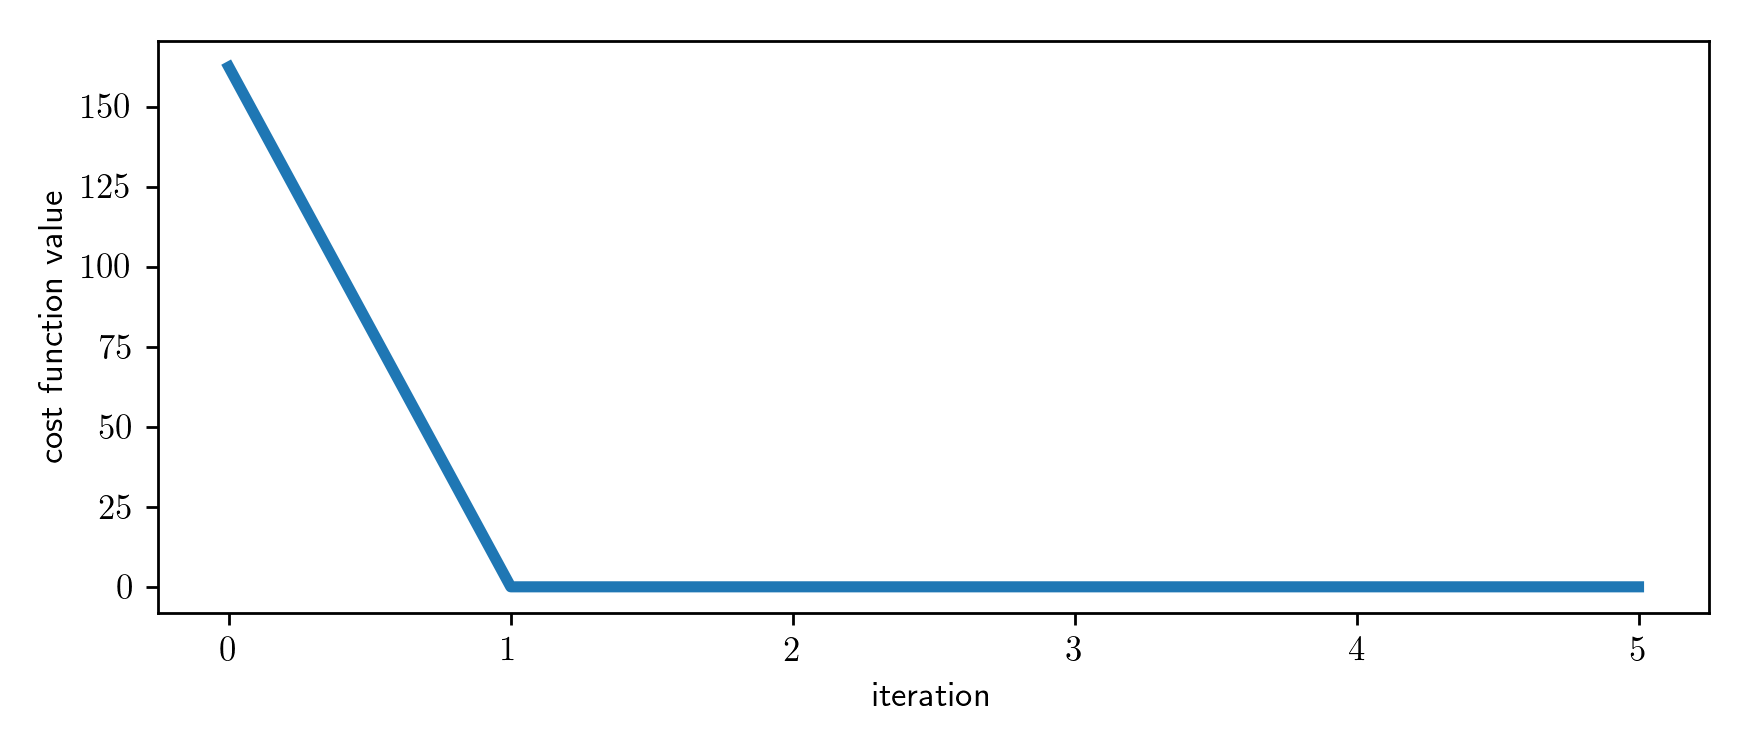

In [23]:
# generate initialization for basis
K = 10
C = np.random.randn(N,K)

# run recommender system
max_its = 5
C_final,W_final,cost_history = Recommender_Systems(X_test,C,max_its=max_its)

# plot cost function history
plotter = unsuplib.plot_utilities.Visualizer()
plotter.plot_cost_history(cost_history)

Now blah blah 

<IPython.core.display.Javascript object>


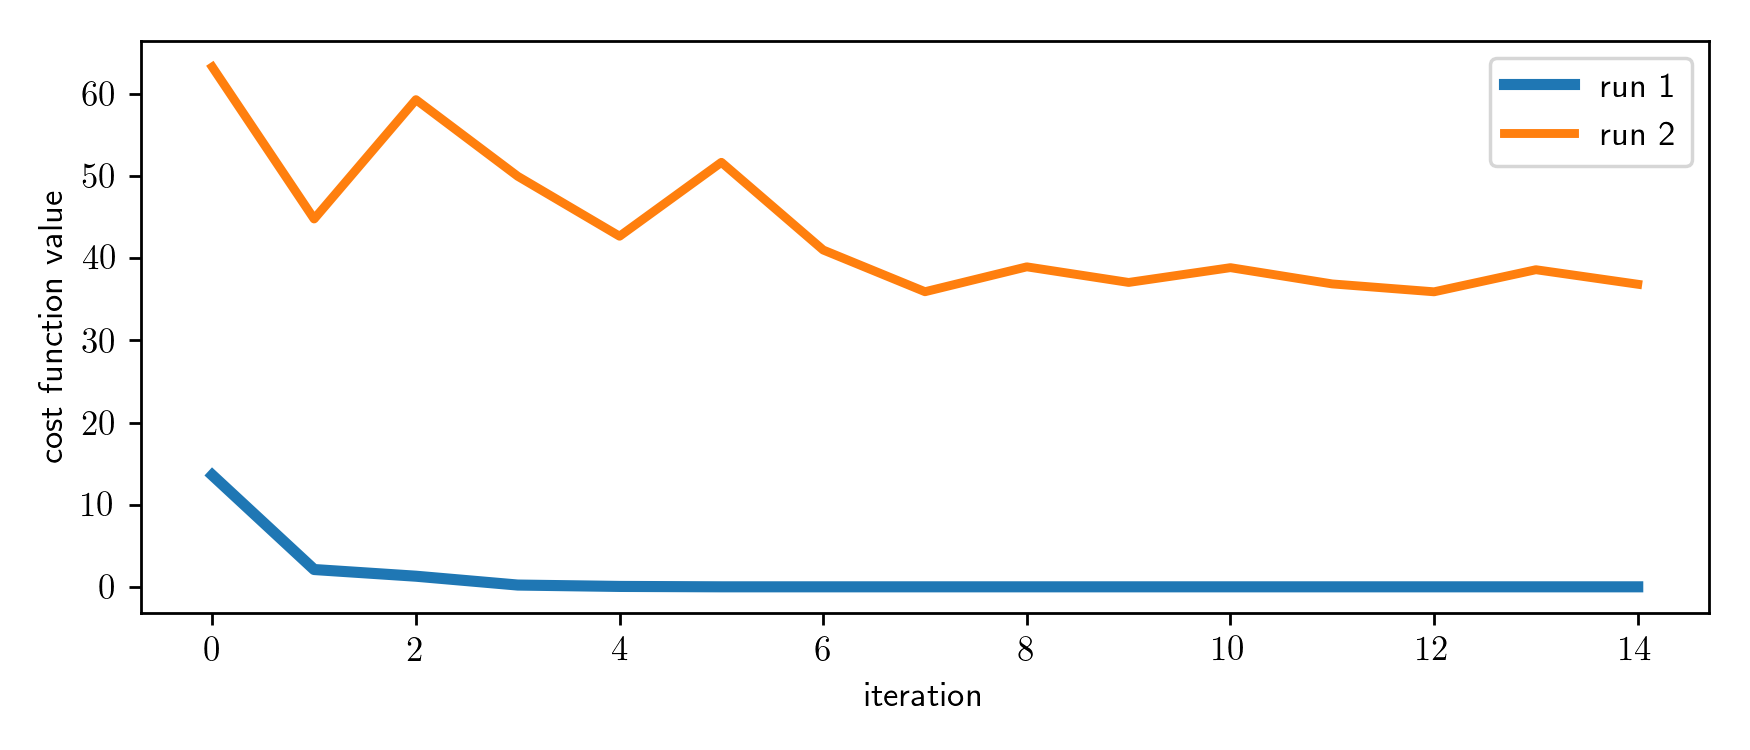

In [136]:
# make a test matrix
N = 10; P = 100; remove_perc = 0.75;
X_complete, X_test = make_random_test_matrix(N,P,remove_perc)

def PCA_cost(X,C,W):
    N,P = np.shape(X)
    pred = np.minimum(np.maximum(np.round(np.dot(C_final,W_final)),0),5)
    return  np.linalg.norm(pred - X,'fro')**2/float(P)

# run loop over different K
my_Ks = np.arange(1,16)
partial_costs = []
full_costs = []
for K in my_Ks:
    # generate initialization for basis
    C = np.random.randn(N,K)

    # run recommender system
    max_its = 5
    C_final,W_final,cost_history = Recommender_Systems(X_test,C,max_its=max_its)
    partial_costs.append(np.min(cost_history))
    
    # record error on entire original matrix
    cost = PCA_cost(X_complete,C_final,W_final)
    full_costs.append(cost)
    
# plot cost function history
plotter = unsuplib.plot_utilities.Visualizer()
histories = [partial_costs,full_costs]
plotter.compare_histories(histories)